In [11]:
import sys
sys.path.append("../src")

### Load Q&A test data

In [2]:
!mc cp s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/q_and_a_scored_filtered_Phi-3-mini-128k-instruct.csv ../data/q_and_a_ref_retrieval_evaluation_Phi-3-mini-128k-instruct.csv

]11;?\

...struct.csv: 281.66 KiB / 281.66 KiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 1.85 MiB/s 0s

### Load Knowledge Data

In [4]:
!mc cp s3/projet-llm-insee-open-data/data/eval_data/eval_retrieval/insee_documents_sample_ref_retrieval_evaluation.csv ../data/insee_documents_sample_ref_retrieval_evaluation.csv

...uation.csv: 4.69 MiB / 4.69 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 26.66 MiB/s 0s

In [12]:
import pandas as pd 

#question and answer
path_qa = "../data/q_and_a_ref_retrieval_evaluation_Phi-3-mini-128k-instruct.csv"
test = pd.read_csv(path_qa)

df_dict = {}
df_dict["the_df_dataset"] = test

#knowledge data 
path_knowledge = "../data/insee_documents_sample_ref_retrieval_evaluation.csv"
data = pd.read_csv(path_knowledge)

In [6]:
display(test.head())
display(data.head())

,context,question,answer,source_doc,groundedness_score,groundedness_eval,relevance_score,relevance_eval,standalone_score,standalone_eval
0,. L’approche coût-efficacité apparaît plus con...,Quelle est l'approche qui s'aligne sur l'objec...,L'approche coût-efficacité est celle qui s'ali...,https://www.insee.fr/fr/information/4796342,5.0,Le contexte fourni donne des informations sur ...,4.0,Cette question est très pertinente pour les ag...,5.0,La question mentionne explicitement l'accord d...
1,". A contrario, pour les femmes de 30à 34ans, i...",Quelle est l'évolution de l'âge moyen à la mat...,L'âge moyen à la maternité pour les femmes de ...,https://www.insee.fr/fr/statistiques/4238437,5.0,La question demande une évolution spécifique c...,5.0,Cette question est très pertinente pour les ag...,5.0,Cette question est indépendante du contexte ca...
2,. Points d’entrées pour la France dans les coo...,Quelle est la part des mineurs dans les cas de...,La part des mineurs a diminué de 7 points pour...,https://www.insee.fr/fr/statistiques/5763625,4.0,Le contexte fournit des informations détaillée...,4.0,Cette question est très pertinente pour les ag...,4.0,Cette question est assez indépendante du conte...
3,. L’empreinte énergétique directe du numérique...,Quelle est la part du numérique dans les émiss...,"En 2017, le numérique représentait plus de 3,7...",https://www.insee.fr/fr/statistiques/4126596,5.0,Le contexte fourni donne des informations spéc...,5.0,Cette question est très pertinente pour les ag...,4.0,Cette question demande des informations spécif...
4,. La collecte d’Acemo Covid s’étend sur deux ...,Quels sont les codes APE utilisés pour représe...,Les codes APE utilisés pour représenter la res...,https://www.insee.fr/fr/statistiques/5392036,5.0,La question demande de nommer les codes APE co...,4.0,Cette question est directement liée aux activi...,5.0,La question demande une information spécifique...


,content,source,title,insee_id,categories,date_diffusion,themes,collections,libelleAffichageGeo,intertitres,authors,subtitle
0,"La Base tous salariés (BTS), extraite de la Dé...",https://www.insee.fr/fr/information/2407785,Base Tous Salariés,2407785,Services,2023-10-03T12:04:14.154Z,NaN,NaN,NaN,Description des variables des différents fichi...,[],BTS
1,"En France, en mars-avril 2020, un surcroît de ...",https://www.insee.fr/fr/statistiques/4797670,Les inégalités sociales à l’épreuve de la cris...,4797670,Publications grand public,2020-12-03T17:00:25.538Z,"[""Revenus – Niveaux de vie – Pouvoir d'achat""]","France, portrait social",France,Décrire au mieux l’impact de la crise sanitair...,"['Meriam Barhoumi (Depp)', 'Anne Jonchery', 'P...",NaN
2,L'Insee a conçu une base historique des Recens...,https://www.insee.fr/fr/information/1303688,RP Historiques et Données harmonisées des rece...,1303688,Services,2023-04-25T09:00:14.283Z,NaN,NaN,NaN,Description des variables des différents\n ...,[],NaN
3,"Il ne faut pas confondre l'arrondissement, sub...",https://www.insee.fr/fr/information/1303686,Recensement de la population de 2006 à 2020,1303686,Services,2023-09-06T06:37:14.496Z,NaN,NaN,NaN,Description des variables des différents\n ...,[],NaN
4,"En 2018, l’économie française ralentit: le pro...",https://www.insee.fr/fr/statistiques/4174895,"En 2018, l’économie française ralentit, après ...",4174895,Publications grand public,2019-06-28T16:00:00Z,['Évolution et structure de la population'],L'économie française - Comptes et dossiers,France,Figure 1 - Contribution des principaux agrégat...,"['Victor\xa0Barry', 'Thibault Cruzet', 'Domini...",NaN


### About test data 

In [96]:
data.nunique()

content                100
source                 100
title                  100
insee_id               100
categories               4
date_diffusion          56
themes                  37
collections             13
libelleAffichageGeo      3
intertitres            100
authors                 96
subtitle                25
dtype: int64

In [97]:
data.isna().sum()

content                 0
source                  0
title                   0
insee_id                0
categories              0
date_diffusion          0
themes                 45
collections            45
libelleAffichageGeo    45
intertitres             0
authors                 0
subtitle               75
dtype: int64

In [ ]:
# Run the evaluator
results = RetrievalEvaluator.run(
    eval_configurations=eval_configs,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)


In [5]:
eval_configs

[RetrievalConfiguration(name='ensemble', database='chromadb', database_path='../data/insee_documents_sample_ref_retrieval_evaluation.csv', embedding_model_name='OrdalieTech/Solon-embeddings-large-0.1', collection='data_test', chunk_size=2000, overlap_size=500, reranker_type='Ensemble', reranker_name=None, param_ensemble=[{'reranker_type': 'Cross-encoder', 'reranker_name': 'BAAI/bge-reranker-base', 'reranker_weight': 0.25}, {'reranker_type': 'BM25', 'reranker_name': None, 'reranker_weight': 0.25}, {'reranker_type': 'ColBERT', 'reranker_name': 'antoinelouis/colbertv2-camembert-L4-mmarcoFR', 'reranker_weight': 0.25}, {'reranker_type': 'Metadata', 'reranker_name': 'title', 'reranker_weight': 0.25}], use_metadata=None, rerank_k=50, k_values=[1, 2, 3, 5, 10, 20, 30, 50], markdown_separator=['\n\n', '\n', '.', ' ', ''])]

### Test 03/07/2024 - Update Retrieval Evaluation process

In [3]:
import matplotlib.pyplot as plt 
from typing import List, Dict 
import math
from evaluation import RetrievalConfiguration

def plot_results(eval_configs: List[RetrievalConfiguration], results: Dict[str, Dict[str, Dict[int, float]]], 
                    ir_metrics: List[str] = ['recall', 'precision', 'mrr', 'ndcg'], focus: str = None, 
                    title: str = "", k: int = 15, cmap_name: str = "tab10"):
    """
    Plots IR metrics for different retrieval configurations.
    
    Parameters:
    - eval_configs: List of RetrievalConfiguration objects.
    - results: Dictionary of results where the keys are configuration names and values are dictionaries 
               of metrics.
    - ir_metrics: List of metrics to plot (default is ['recall', 'precision', 'mrr', 'ndcg']).
    - focus: The name of the config parameter to highlight in the legend.
    - title: The title of the plot.
    - k: The maximum value of k to plot.
    """

    # dynamic plotting  
    num_metrics = len(ir_metrics)
    num_cols = math.ceil(math.sqrt(num_metrics))
    num_rows = math.ceil(num_metrics / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
    axes = axes.flatten() if num_metrics > 1 else [axes]

    cmap = plt.get_cmap(cmap_name)
    colors = cmap(range(len(eval_configs)))
    
    for i, metric in enumerate(ir_metrics):
        ax = axes[i]

        for j, config in enumerate(eval_configs):
            config_results = results.get(config.name, {})
            metric_values = config_results.get(metric, {})
            
            k_values = [key for key in config.k_values if key <= k]
            values = [metric_values.get(ki, None) for ki in k_values]

            label = config.get(focus) 

            if label is None:
                label = config.name
            ax.plot(k_values, values, marker='o', label=label.split("/")[-1], color=colors[j])
        
        ax.set_xlabel('k')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.upper()} vs k')
        ax.set_xticks(k_values)
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()
    
def hist_results(eval_configs: List[RetrievalConfiguration], results: Dict[str, Dict[str, Dict[int, float]]], 
                 ir_metrics: List[str] = ['recall', 'precision', 'mrr', 'ndcg'], focus: str = None, 
                 title: str = "", k: int = 15, cmap_name : str = 'tab10', x_min=0.6):
    """
    Plots histograms of IR metrics for different retrieval configurations at a given k.
    
    Parameters:
    - eval_configs: List of RetrievalConfiguration objects.
    - results: Dictionary of results where the keys are configuration names and values are dictionaries 
               of metrics.
    - ir_metrics: List of metrics to plot (default is ['recall', 'precision', 'mrr', 'ndcg']).
    - focus: The name of the config parameter to highlight in the legend.
    - title: The title of the plot.
    - k: The value of k to plot the histograms for.
    """
    num_metrics = len(ir_metrics)
    num_cols = math.ceil(math.sqrt(num_metrics))
    num_rows = math.ceil(num_metrics / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
    axes = axes.flatten() if num_metrics > 1 else [axes]

    cmap = plt.get_cmap(cmap_name)
    colors = cmap(range(len(eval_configs)))

    for i, metric in enumerate(ir_metrics):
        ax = axes[i]
        values = []
        labels = []
        
        for j, config in enumerate(eval_configs):
            config_results = results.get(config.name, {})
            metric_values = config_results.get(metric, {})
            if isinstance(metric_values, dict):
                value = metric_values.get(k, None)
            else:
                value = metric_values
            
            if value is not None:
                values.append(value)
                label = config.get(focus) 
                if label is None:
                    label = config.name
                labels.append(label.split("/")[-1])
                ax.barh(labels[-1], values[-1], color=colors[j])
        
        ax.set_xlabel('Value')
        ax.set_ylabel('Configuration')
        ax.set_xlim(left=x_min)
        ax.set_title(f'{metric.upper()} at k={k}')
        ax.grid(True)
    
    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()
    

### Test Cross-encoder

In [ ]:
from evaluation import RetrievalConfiguration, RetrievalEvaluator

cross_encoders = ["BAAI/bge-reranker-v2-m3", "antoinelouis/crossencoder-camembert-large-mmarcoFR", "dangvantuan/CrossEncoder-camembert-large","antoinelouis/crossencoder-electra-base-french-mmarcoFR", "BAAI/bge-reranker-base"]

eval_configs = [RetrievalConfiguration(
        name=f'test_cross_encoder_{i}',
        database="chromadb",
        collection="Solon-embeddings-large-0.1_512_51",
        database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="Cross-encoder",
        reranker_name=cross_encoder,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 20, 30, 50]
    ) for i,cross_encoder in enumerate(cross_encoders)] + [RetrievalConfiguration(
        name=f'test_baseline',
        database="chromadb",
        collection="Solon-embeddings-large-0.1_512_51",
        database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 20, 30, 50]
    )]

# Run the evaluator
results = RetrievalEvaluator.run(
    eval_configurations=eval_configs,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

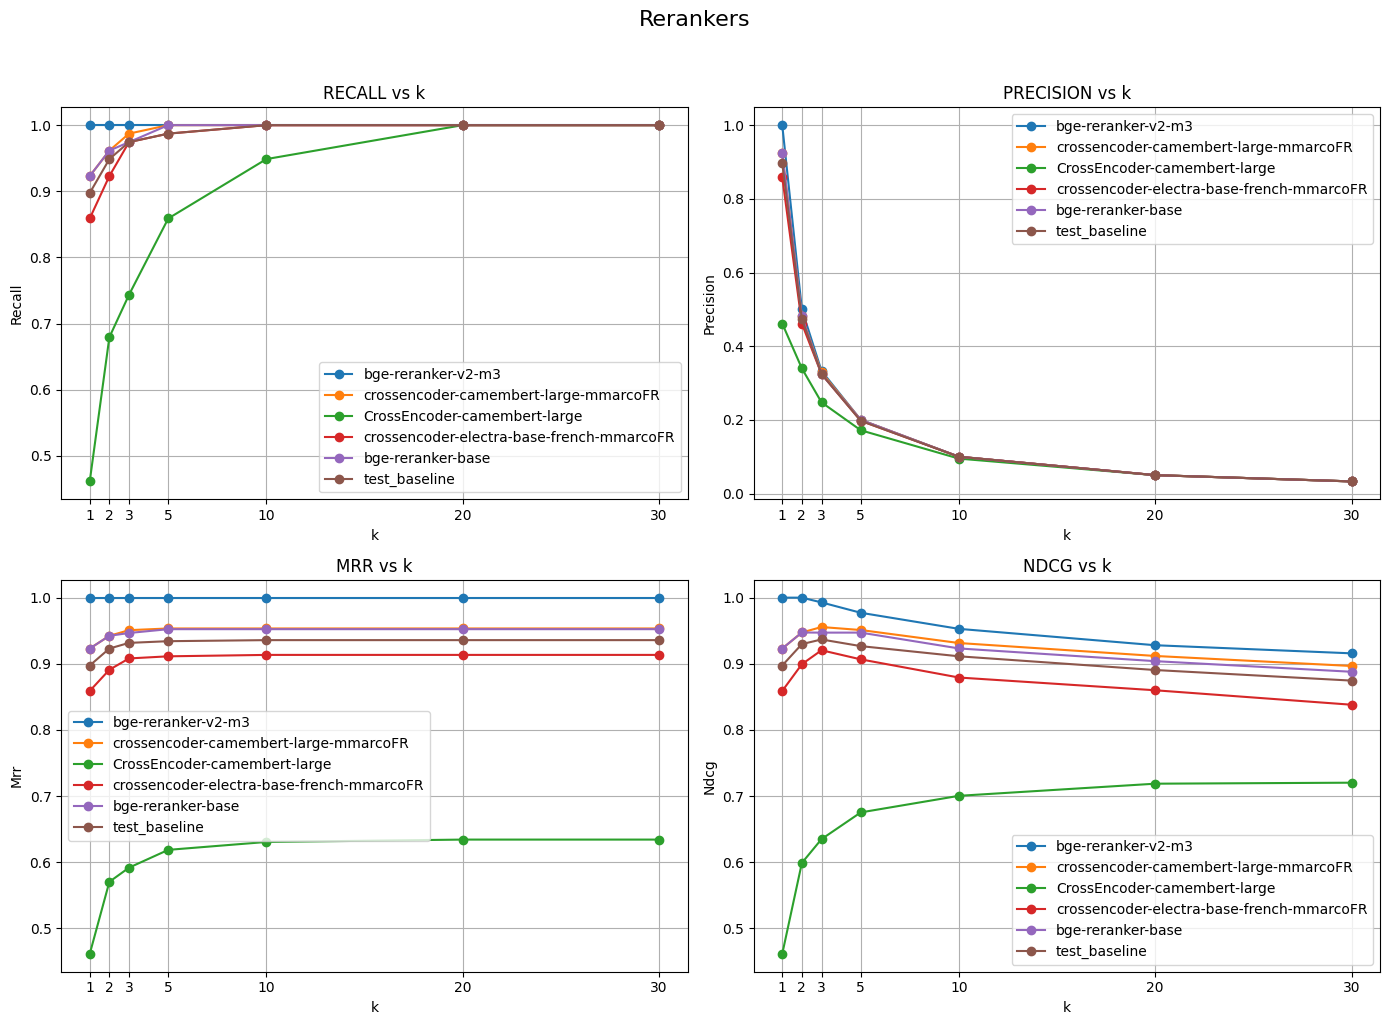

In [75]:
plot_results(
    eval_configs, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg'], 
    focus="reranker_name", 
    title = "Rerankers",
    k = 30)

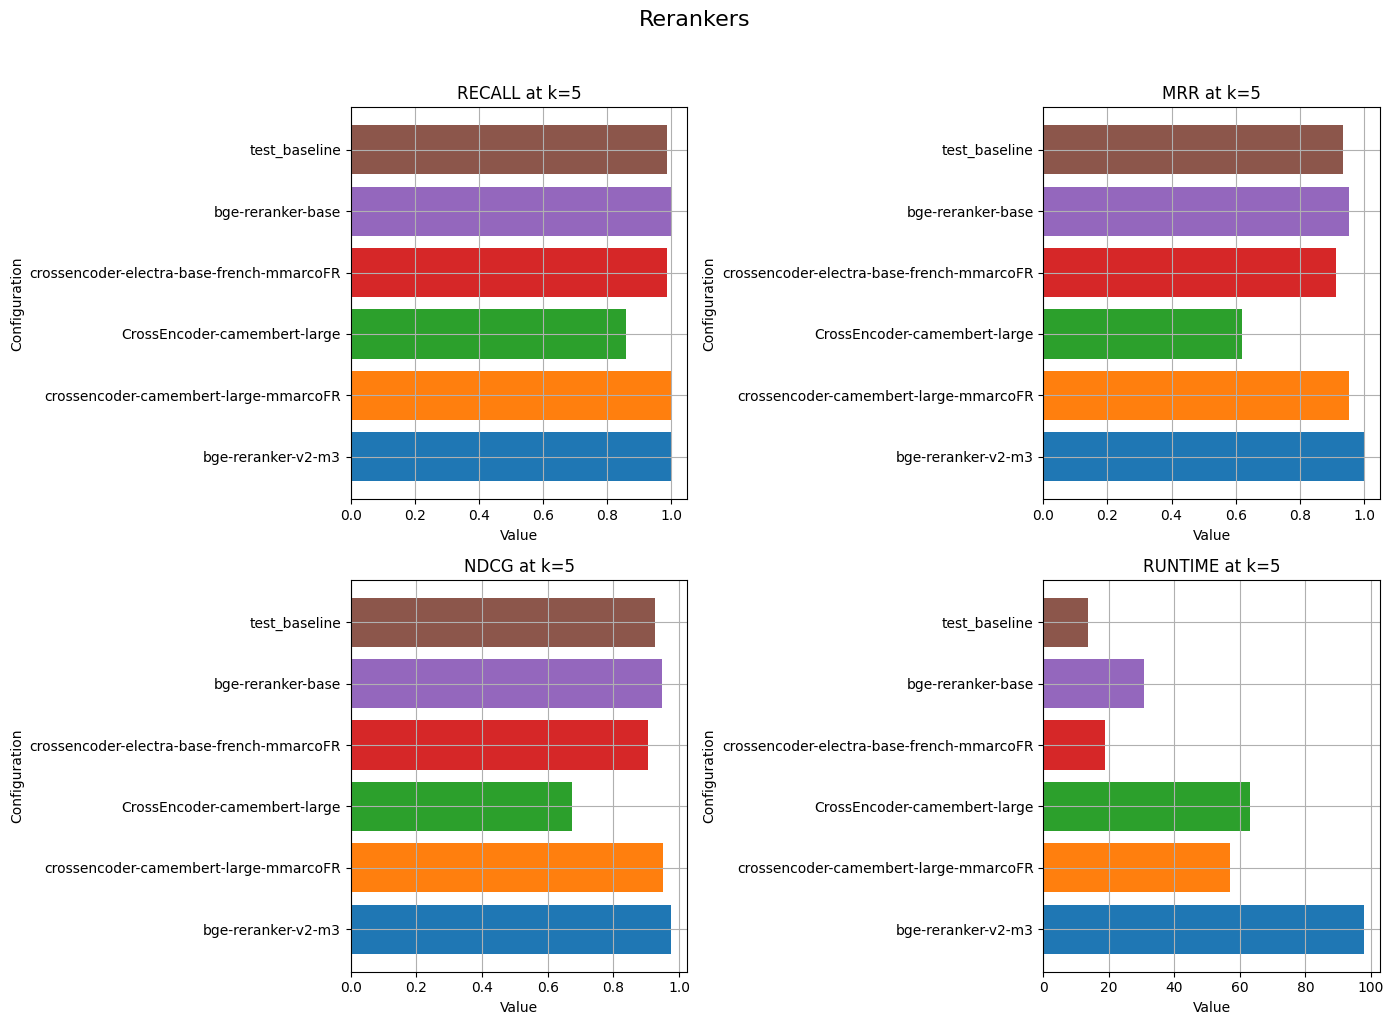

In [76]:
hist_results(
    eval_configs, 
    results["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg','runtime'], 
    focus="reranker_name", 
    title = "Rerankers",
    k = 5)

### Test ColBERTs

In [ ]:
colberts = ["colbert-ir/colbertv2.0", "bclavie/FraColBERTv2", "antoinelouis/colbertv2-camembert-L4-mmarcoFR","antoinelouis/colbertv1-camembert-base-mmarcoFR"]

eval_configs_colbert = [RetrievalConfiguration(
        name=f'test_colBERT_{i}',
        database="chromadb",
        collection="Solon-embeddings-large-0.1_512_51",
        database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="ColBERT",
        reranker_name=colbert,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
    ) for i, colbert in enumerate(colberts)] + [RetrievalConfiguration(
        name=f'test_baseline',
        database="chromadb",
        collection="Solon-embeddings-large-0.1_512_51",
        database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
    )]

# Run the evaluator
results_colbert = RetrievalEvaluator.run(
    eval_configurations=eval_configs_colbert,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

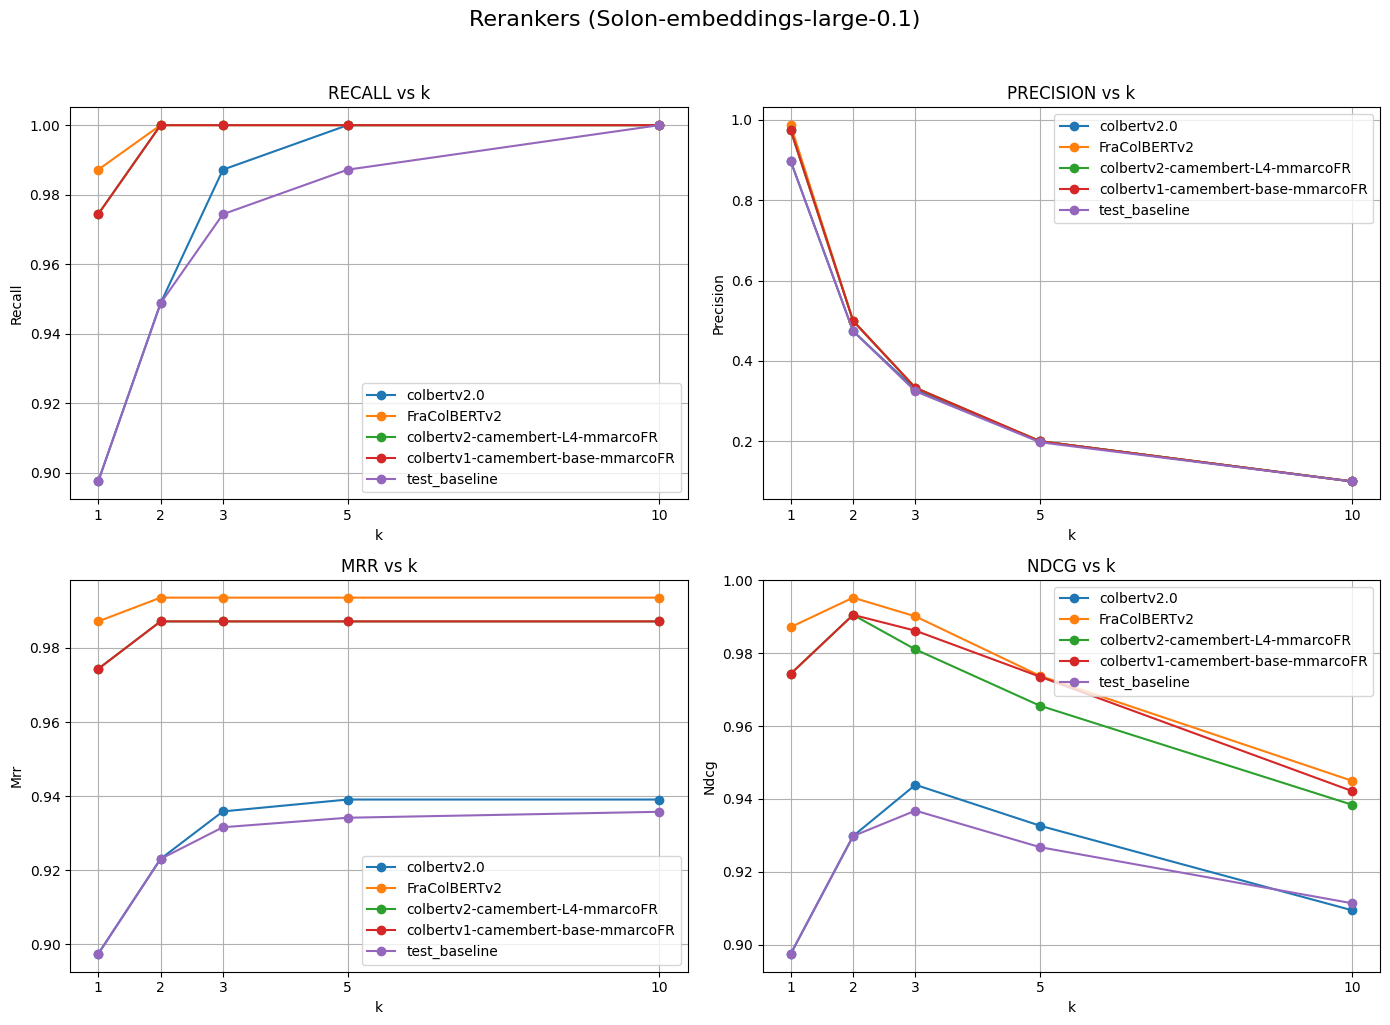

In [85]:
plot_results(
    eval_configs_colbert, 
    results_colbert["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg'], 
    focus="reranker_name", 
    title="Rerankers (Solon-embeddings-large-0.1)",
    k = 10
    )

In [80]:
eval_configs_colbert

[RetrievalConfiguration(name='test_colBERT_0', database='chromadb', database_path='../data/insee_documents_sample_ref_retrieval_evaluation.csv', embedding_model_name='OrdalieTech/Solon-embeddings-large-0.1', collection='Solon-embeddings-large-0.1_512_51', chunk_size=512, overlap_size=51, reranker_type='ColBERT', reranker_name='colbert-ir/colbertv2.0', param_ensemble={}, use_metadata=None, rerank_k=50, k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50], markdown_separator=['\n\n', '\n', '.', ' ', '']),
 RetrievalConfiguration(name='test_colBERT_1', database='chromadb', database_path='../data/insee_documents_sample_ref_retrieval_evaluation.csv', embedding_model_name='OrdalieTech/Solon-embeddings-large-0.1', collection='Solon-embeddings-large-0.1_512_51', chunk_size=512, overlap_size=51, reranker_type='ColBERT', reranker_name='bclavie/FraColBERTv2', param_ensemble={}, use_metadata=None, rerank_k=50, k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50], markdown_separator=['\n\n', '\n'

In [82]:
results_colbert["the_df_dataset"]["test_colBERT_2"]

{'recall': {1: 0.9743589743589743,
  2: 1.0,
  3: 1.0,
  5: 1.0,
  10: 1.0,
  15: 1.0,
  20: 1.0,
  25: 1.0,
  30: 1.0,
  35: 1.0,
  45: 1.0,
  50: 1.0},
 'precision': {1: 0.9743589743589743,
  2: 0.5,
  3: 0.3329999999999999,
  5: 0.19999999999999993,
  10: 0.09999999999999996,
  15: 0.06700000000000002,
  20: 0.04999999999999998,
  25: 0.04,
  30: 0.032999999999999995,
  35: 0.028999999999999995,
  45: 0.021999999999999995,
  50: 0.02},
 'mrr': {1: 0.9743589743589743,
  2: 0.9871794871794872,
  3: 0.9871794871794872,
  5: 0.9871794871794872,
  10: 0.9871794871794872,
  15: 0.9871794871794872,
  20: 0.9871794871794872,
  25: 0.9871794871794872,
  30: 0.9871794871794872,
  35: 0.9871794871794872,
  45: 0.9871794871794872,
  50: 0.9871794871794872},
 'ndcg': {1: 0.9743589743589743,
  2: 0.990536660347986,
  3: 0.9810456929316743,
  5: 0.9655704650479581,
  10: 0.9384103821665288,
  15: 0.9206861760555939,
  20: 0.9127127943369627,
  25: 0.8977662817449887,
  30: 0.8907041394585229,
  35

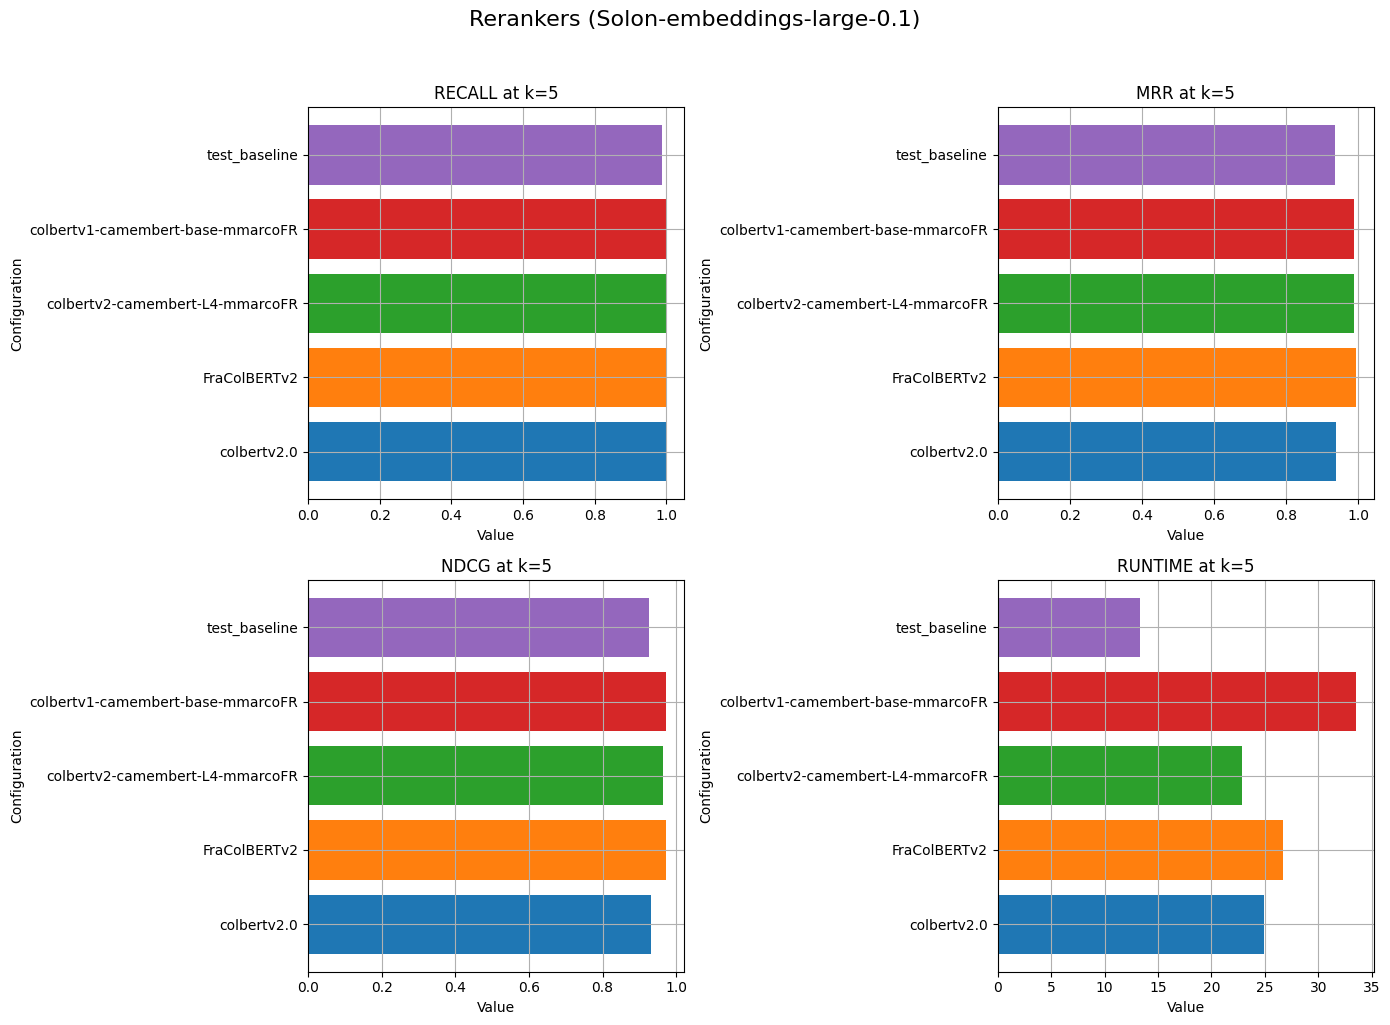

In [92]:
hist_results(
    eval_configs_colbert, 
    results_colbert["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg','runtime'], 
    focus="reranker_name", 
    title = "Rerankers (Solon-embeddings-large-0.1)",
    k = 5)

### Test BM25

In [ ]:
eval_configs_bm25_metadata = [
    RetrievalConfiguration(
        name=f'test_BM25',
        database="chromadb",
        collection="Solon-embeddings-large-0.1_512_51",
        database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="BM25",
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
    ),
    RetrievalConfiguration(
        name=f'test_baseline',
        database="chromadb",
        collection="Solon-embeddings-large-0.1_512_51",
        database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
    )
    ] + [
        RetrievalConfiguration(
            name=f'test_metadata',
            database="chromadb",
            collection="Solon-embeddings-large-0.1_512_51",
            database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
            embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
            reranker_type="Metadata",
            use_metadata=meta,
            reranker_name=None,
            rerank_k=50,
            k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50])
         for meta in ['title', "intertitres", "themes","subtitle", "libelleAffichageGeo"]
    ]
    
# Run the evaluator
results_bm25_metadata = RetrievalEvaluator.run(
    eval_configurations=eval_configs_bm25_metadata,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

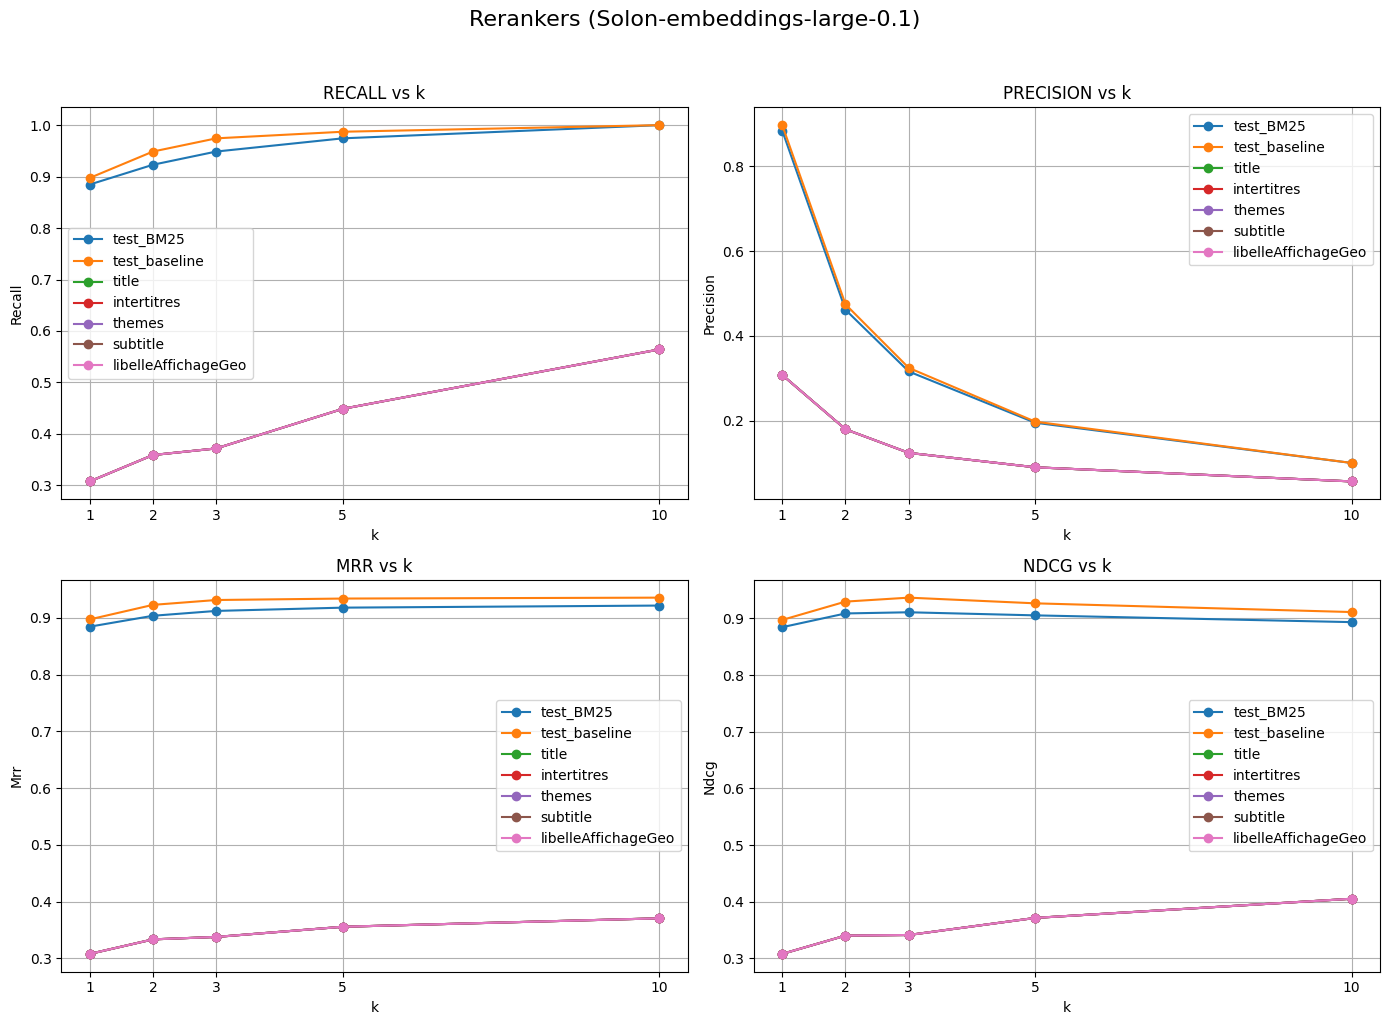

In [107]:
plot_results(
    eval_configs_bm25_metadata, 
    results_bm25_metadata["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg'], 
    focus="use_metadata", 
    title="Rerankers (Solon-embeddings-large-0.1)",
    k = 10
    )

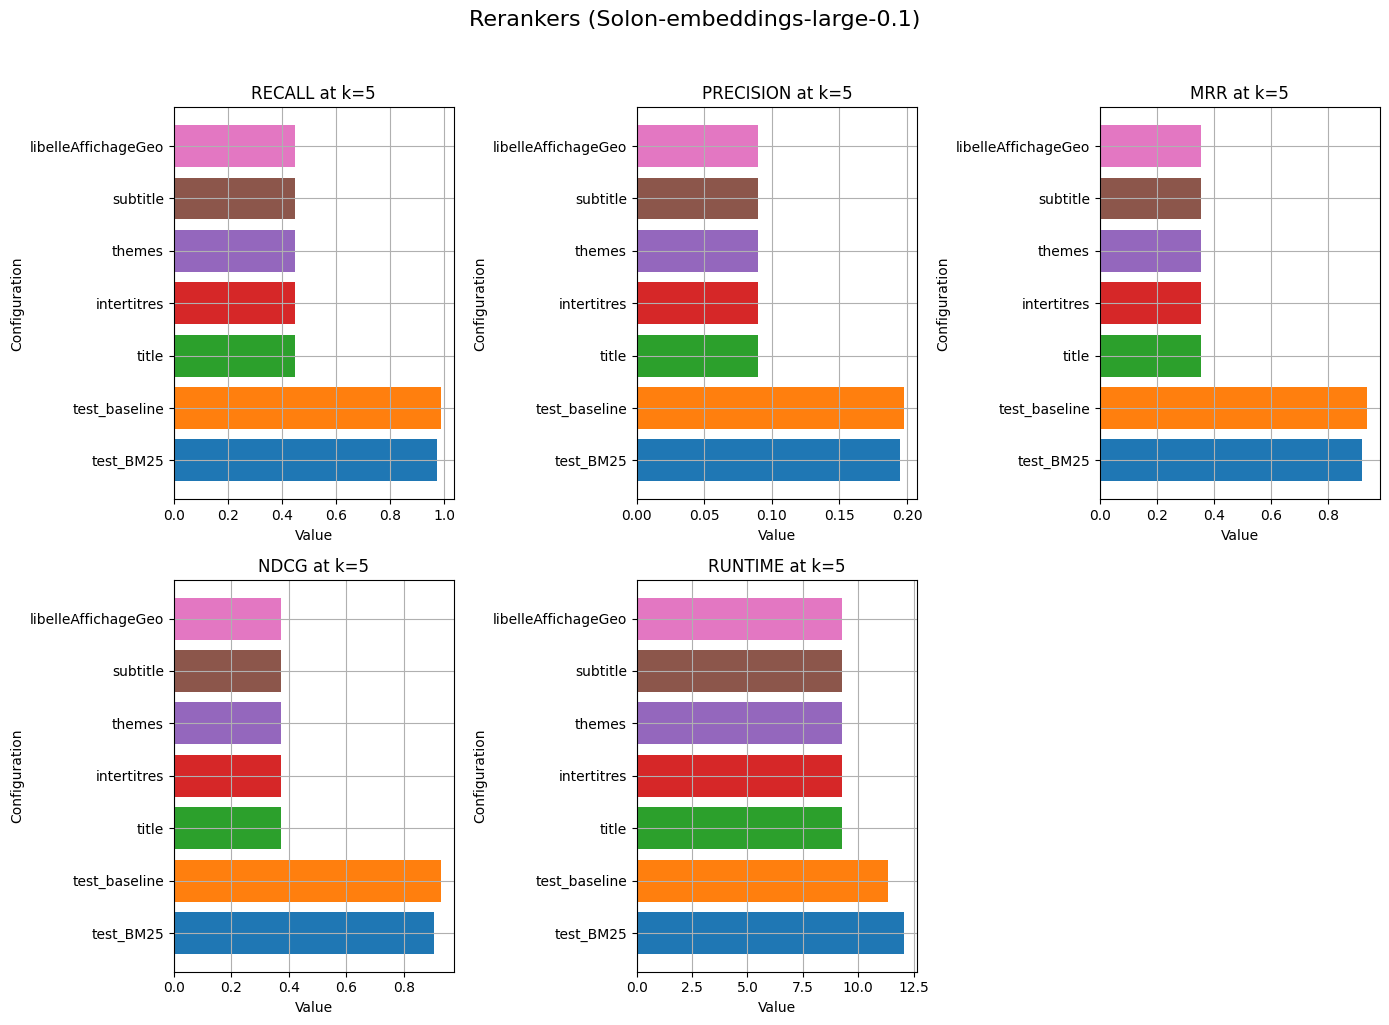

In [108]:
hist_results(
    eval_configs_bm25_metadata, 
    results_bm25_metadata["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg', 'runtime'], 
    focus="use_metadata", 
    title="Rerankers (Solon-embeddings-large-0.1)",
    k = 5
)

### Test Embeddings 

In [ ]:
from evaluation import RetrievalConfiguration, RetrievalEvaluator
model_embeddings = [
    "sentence-transformers/all-MiniLM-L6-v2", 
    "manu/sentence_croissant_alpha_v0.4",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "OrdalieTech/Solon-embeddings-large-0.1",
    "intfloat/multilingual-e5-large",
    "Lajavaness/bilingual-embedding-large",
    ]

eval_configs_embeddings= [
    RetrievalConfiguration(
        name=f'test_embeddings_{i}',
        database="chromadb",
        collection=model.split("/")[-1],
        database_path="../data/insee_documents_sample_ref_retrieval_evaluation.csv",
        embedding_model_name=model,
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 45, 50]
    ) for i, model in enumerate(model_embeddings)
]

# Run the evaluator
results_embeddings = RetrievalEvaluator.run(
    eval_configurations=eval_configs_embeddings,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

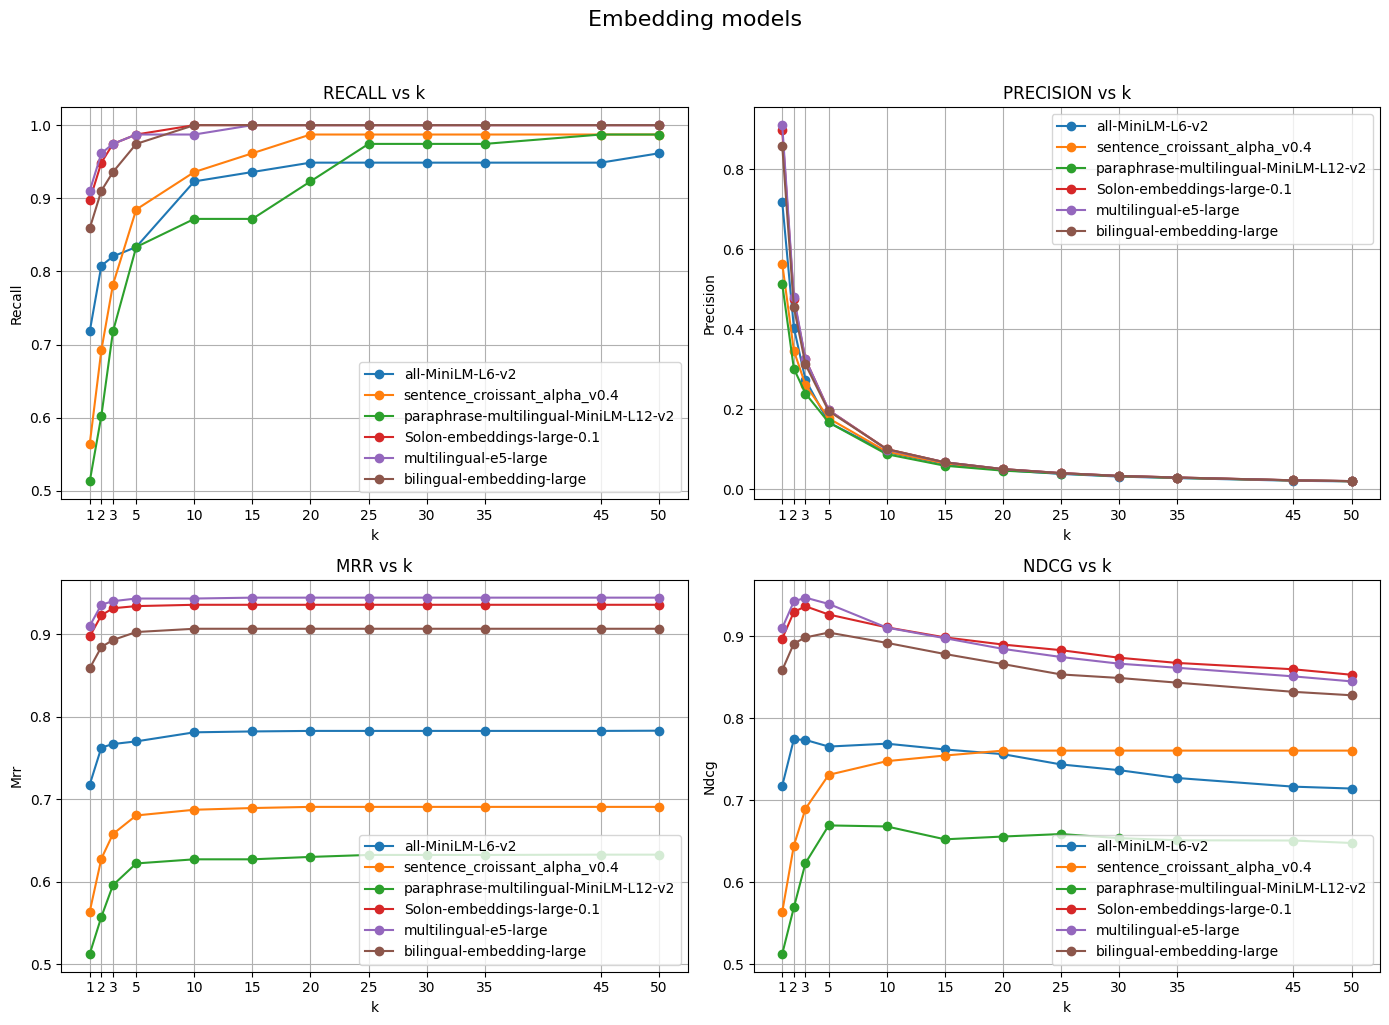

In [6]:
plot_results(
    eval_configs_embeddings, 
    results_embeddings["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg'], 
    focus="embedding_model_name", 
    title="Embedding models",
    k = 50
    )

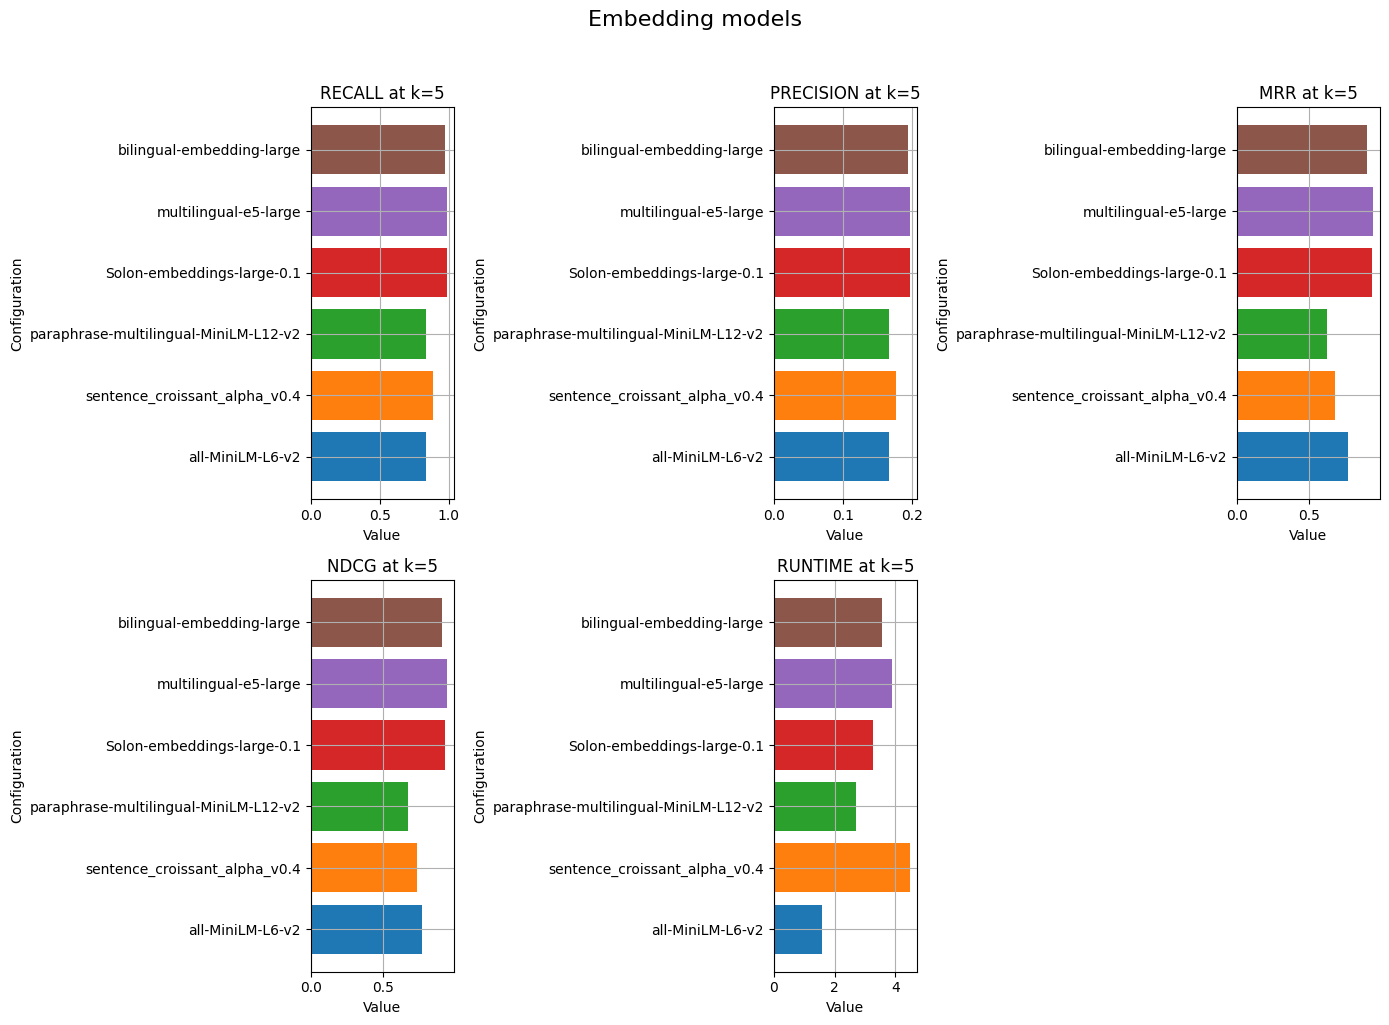

In [9]:
hist_results(
    eval_configs_embeddings, 
    results_embeddings["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg', 'runtime'], 
    focus="embedding_model_name", 
    title="Embedding models",
    k = 5
)

### Ensemble methods 

In [27]:
def generate_sequence(start, step, count):
    """
    Generate a sequence of tuples (x, y) such that x + y = 1.
    
    Parameters:
    start (float): Starting value for the sequence
    step (float): Increment value for each step in the sequence
    count (int): Number of tuples to generate
    
    Returns:
    list: A list of tuples (x, y)
    """
    sequence = []
    for i in range(count):
        x = start + i * step
        y = 1 - x
        sequence.append((x, y))
    return sequence

# Example usage
start = 0.0
step = 0.1
count = 10
list_tuples = generate_sequence(start, step, count)
print(list_tuples)

[(0.0, 1.0), (0.1, 0.9), (0.2, 0.8), (0.30000000000000004, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6000000000000001, 0.3999999999999999), (0.7000000000000001, 0.29999999999999993), (0.8, 0.19999999999999996), (0.9, 0.09999999999999998)]


In [ ]:
ensemble_eval_config = [
    RetrievalConfiguration(
        name='baseline',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        k_values= [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90,100],
        rerank_k= 100
    )
    ] + [
        RetrievalConfiguration(
            name=f'ensemble_{i}_{j}',
            database="chromadb",
            collection="insee_data",
            database_path="",
            embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
            reranker_type="Ensemble",
            param_ensemble = [
                {"reranker_type":"Cross-encoder",
                "reranker_name":"BAAI/bge-reranker-v2-m3",
                "reranker_weight": i
                },
                {"reranker_type":"BM25",
                "reranker_name": None,
                "reranker_weight": j
                },
            ],
             k_values= [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90,100],
            rerank_k = 100
        ) for i,j in [(0.0, 1.0), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6),(0.5, 0.5),(0.6, 0.4),(0.7, 0.3),(0.8, 0.2),(0.9, 0.1),(1.0, 0.0)] 
    ]

# Run the evaluator
results_ensemble = RetrievalEvaluator.run(
    eval_configurations=ensemble_eval_config,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)


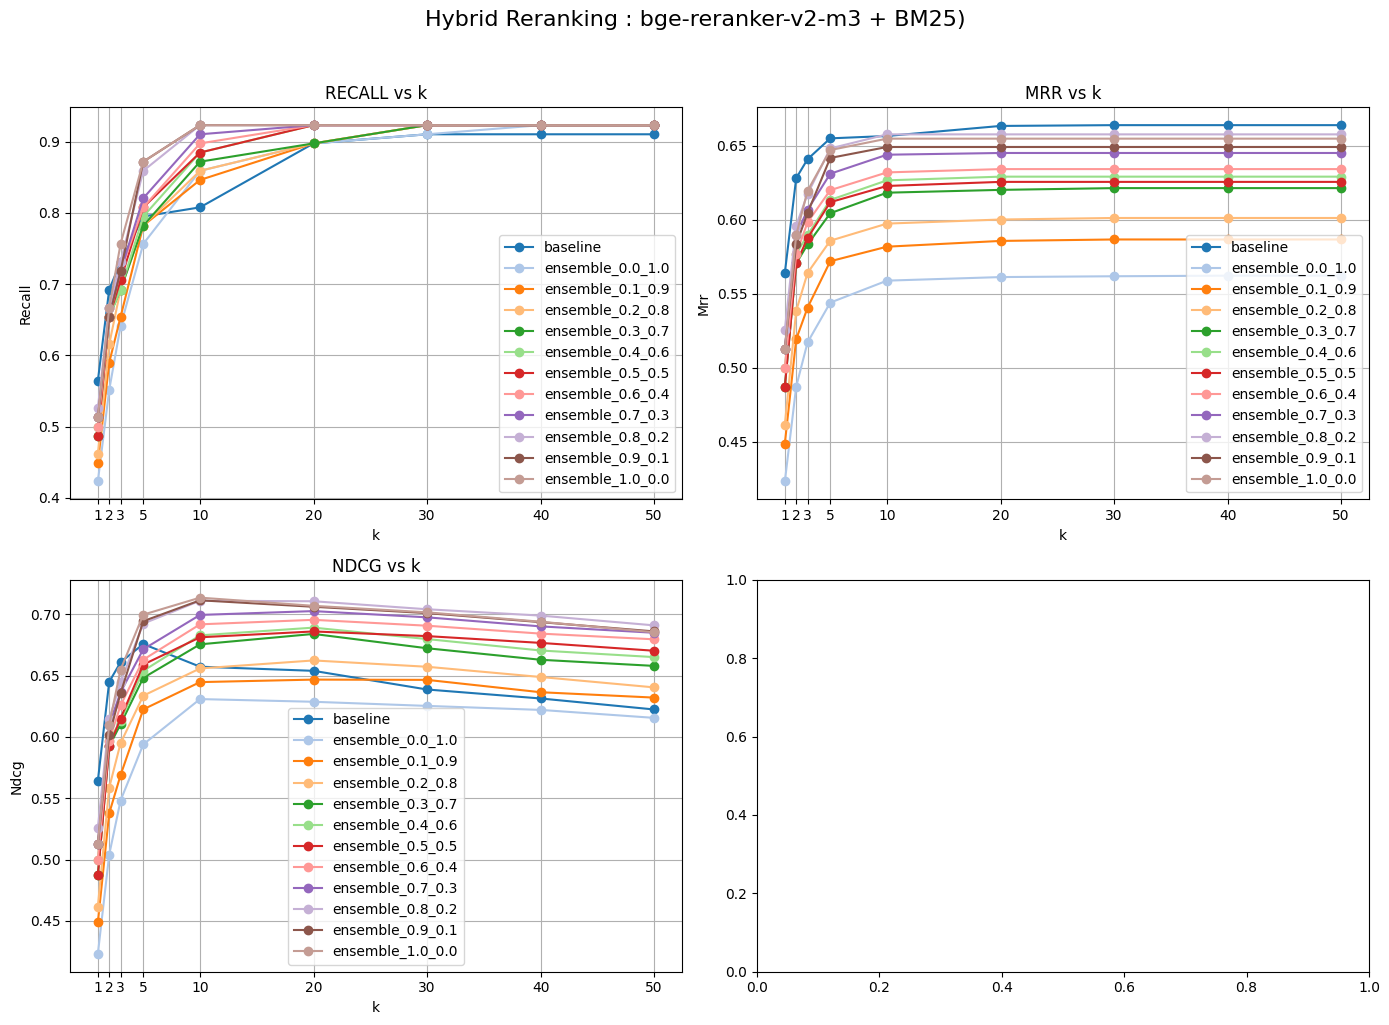

In [20]:
# Run the evaluator
plot_results(
    ensemble_eval_config, 
    results_ensemble["the_df_dataset"], 
    ir_metrics=['recall', 'mrr', 'ndcg'], 
    focus="reranker_name", 
    title = "Hybrid Reranking : bge-reranker-v2-m3 + BM25)",
    k = 50,
    cmap_name = "tab20"
    )

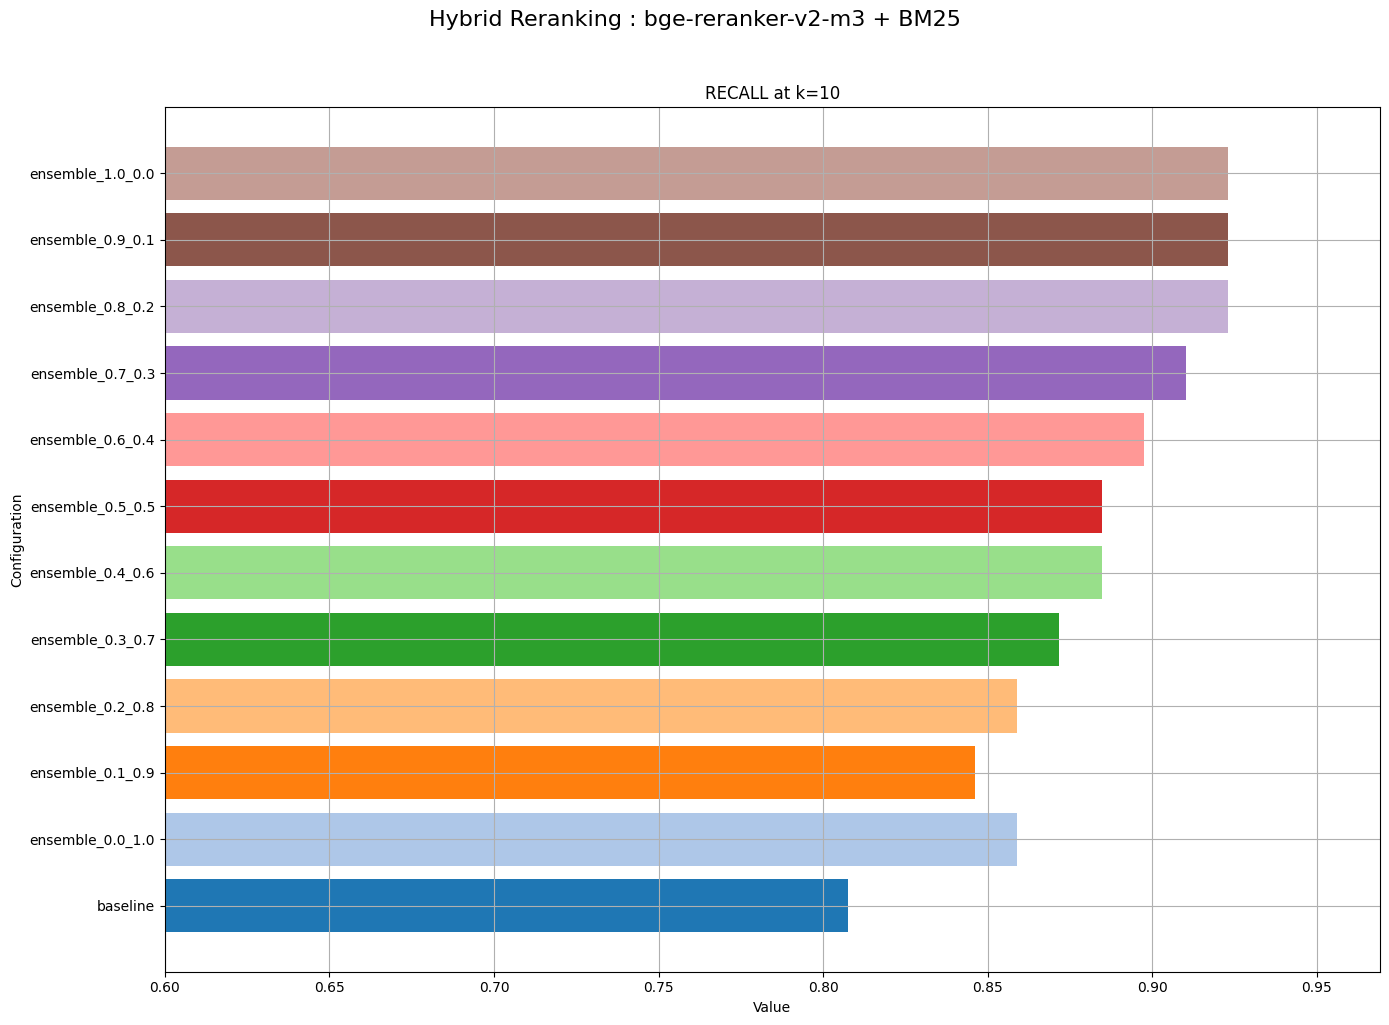

In [30]:
# Run the evaluator
hist_results(
    ensemble_eval_config, 
    results_ensemble["the_df_dataset"], 
    ir_metrics=['recall'], 
    focus="reranker_name", 
    title = "Hybrid Reranking : bge-reranker-v2-m3 + BM25",
    k = 10,
    x_min = 0.6,
    cmap_name = "tab20"
)

### Dense vs Sparse vs Baseline 

In [ ]:
list_config = [RetrievalConfiguration(
        name=f'Dense Reranker (bge-reranker-v2-m3)',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="Cross-encoder",
        reranker_name="BAAI/bge-reranker-v2-m3",
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
RetrievalConfiguration(
        name=f'Dense Reranker (FraColBERTv2)',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="ColBERT",
        reranker_name="bclavie/FraColBERTv2",
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
RetrievalConfiguration(
        name=f'Sparse Reranker (BM25)',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="BM25",
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]),
RetrievalConfiguration(
        name=f'Baseline',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    )
]
# Run the evaluator
results_llm_reranker = RetrievalEvaluator.run(
    eval_configurations = list_config,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

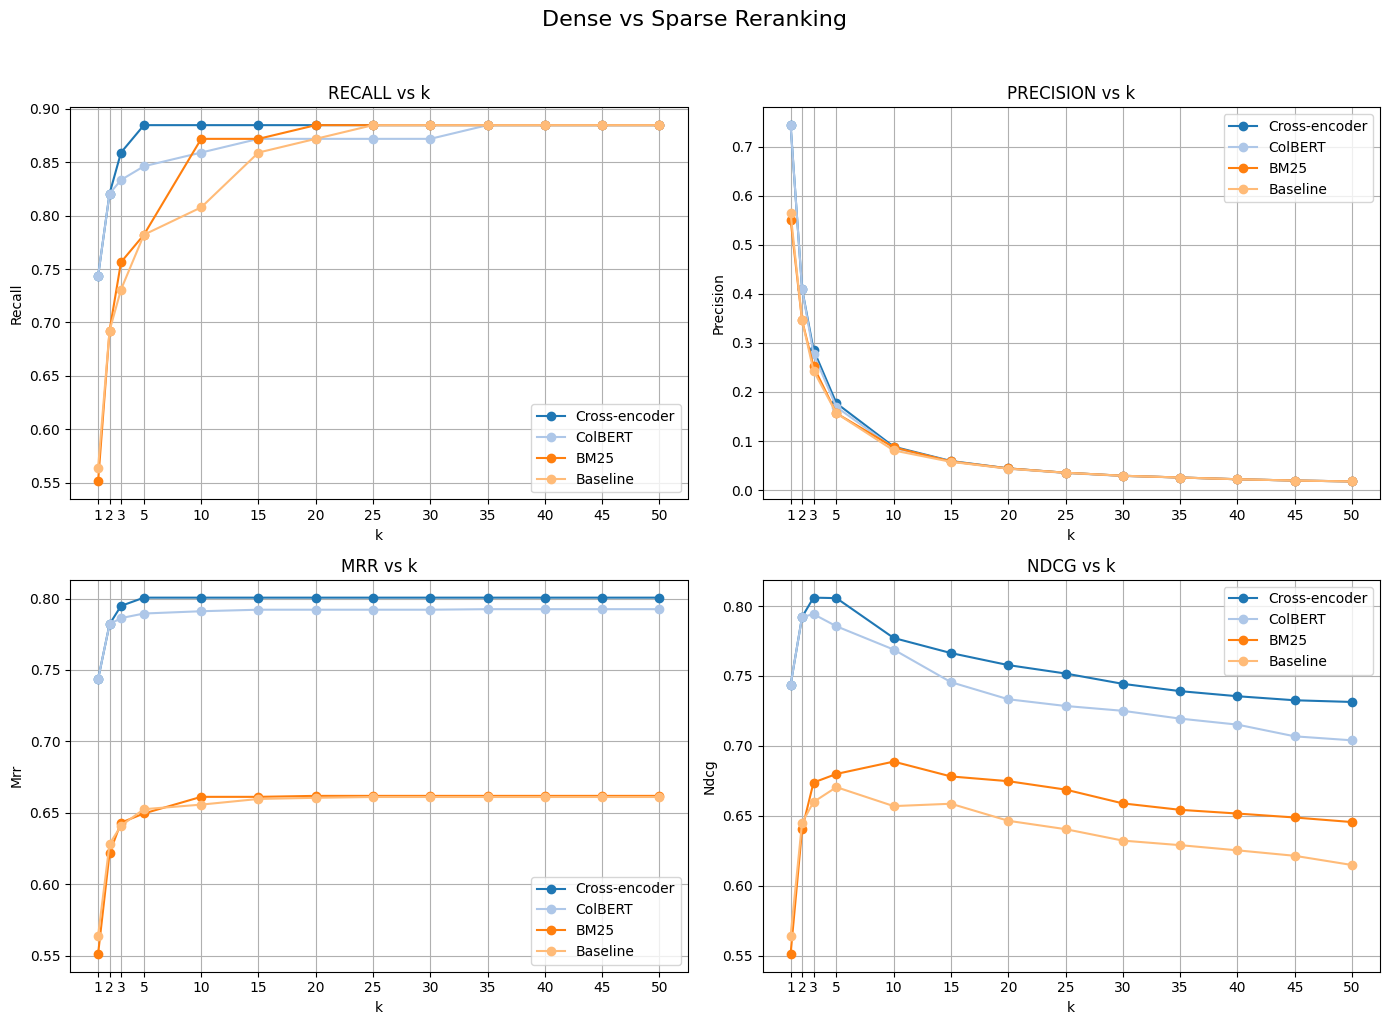

In [43]:
plot_results(
    list_config, 
    results_llm_reranker["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg'], 
    focus="reranker_type", 
    title="Dense vs Sparse Reranking",
    k = 50
    )

In [44]:
for keys in results_llm_reranker["the_df_dataset"].keys():
    print(keys ," : ", float(results_llm_reranker["the_df_dataset"][keys]["runtime"])/78)

Dense Reranker (bge-reranker-v2-m3)  :  0.7066773481858082
Dense Reranker (FraColBERTv2)  :  0.23309259231273943
Sparse Reranker (BM25)  :  0.04667813349992801
Baseline  :  0.03588975392855131


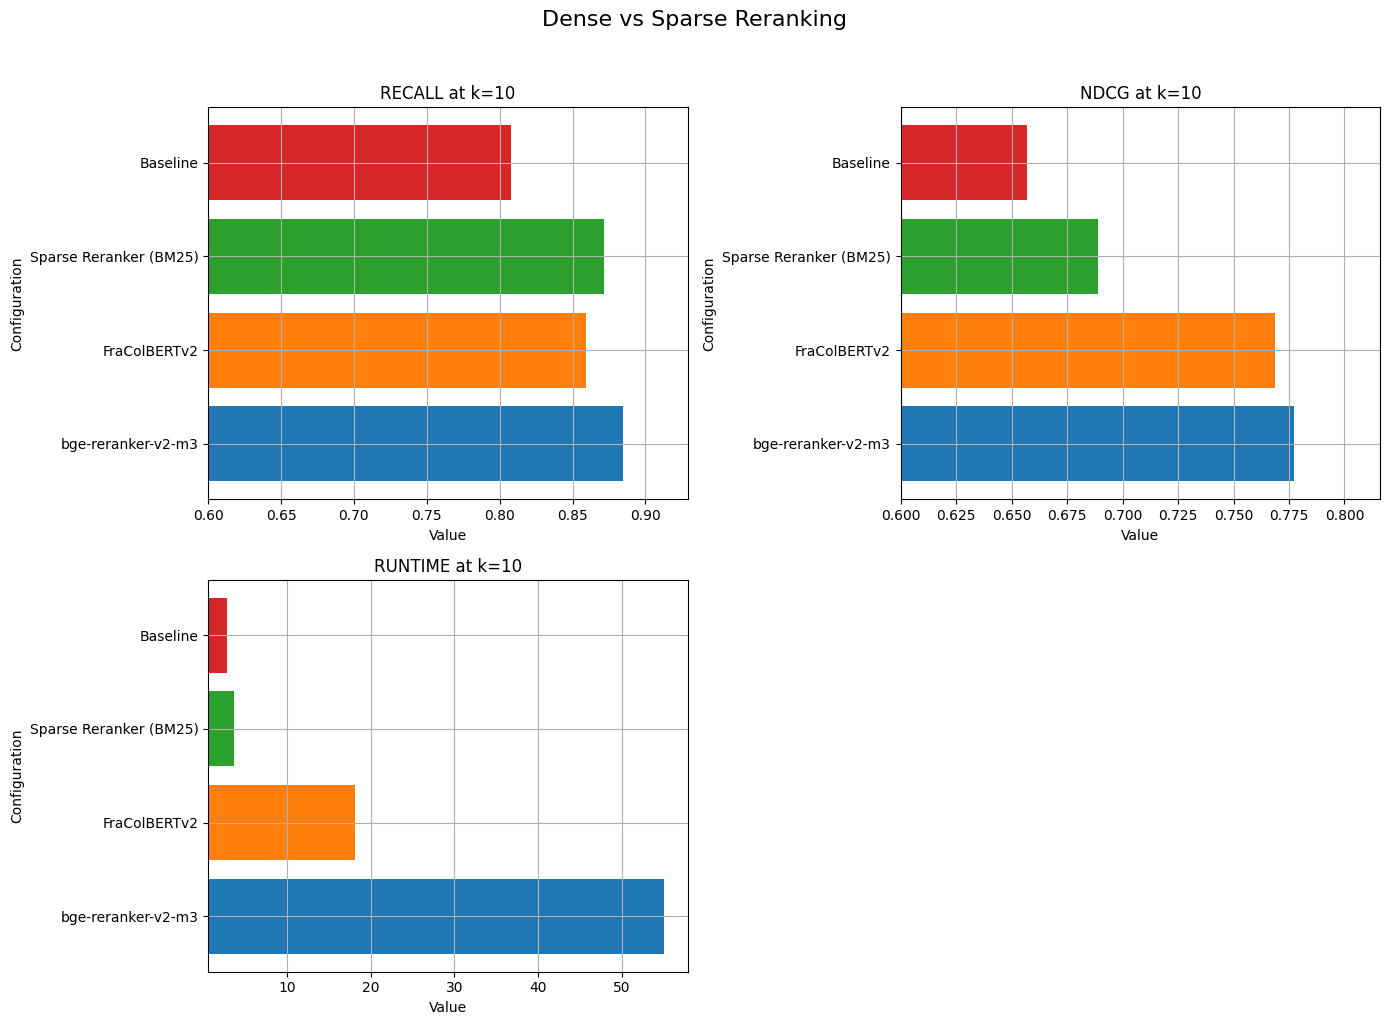

In [52]:
# Run the evaluator
hist_results(
    list_config, 
    results_llm_reranker["the_df_dataset"], 
    ir_metrics=['recall','ndcg', 'runtime'], 
    focus="reranker_name", 
    title = "Dense vs Sparse Reranking",
    k = 10,
    x_min = 0.6,
    cmap_name = "tab10"
)

### 21/08/2024 - LLM as a Reranker Test

In [ ]:
from evaluation import RetrievalConfiguration, RetrievalEvaluator

eval_configs_llm_reranker = [
    RetrievalConfiguration(
        name=f'Reranker llm {method}',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type="LLM",
        reranker_name="meta-llama/Meta-Llama-3-8B-Instruct",
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    ) for method in ["RG_S", "RG_YN", "RG_3L","RG_4L"] 
] + [RetrievalConfiguration(
        name=f'baseline',
        database="chromadb",
        collection="insee_data",
        database_path="",
        embedding_model_name="OrdalieTech/Solon-embeddings-large-0.1",
        reranker_type=None,
        reranker_name=None,
        rerank_k=50,
        k_values=[1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    )]

df_dict["the_df_dataset"] = test.head(10)

# Run the evaluator
results_llm_reranker = RetrievalEvaluator.run(
    eval_configurations = eval_configs_llm_reranker,
    eval_dict=df_dict,  # Ensure 'df_dict' is a dictionary containing pandas DataFrames with the required structure
)

In [6]:
from evaluation.utils import plot_results, hist_results

In [ ]:
plot_results(
    eval_configs_llm_reranker, 
    results_llm_reranker["the_df_dataset"], 
    ir_metrics=['recall', 'precision', 'mrr', 'ndcg'], 
    focus="reranker_type", 
    title="LLM-as-a-reranker",
    k = 50
    )